In [21]:
import pickle
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('../../realtorbot')
from locations import *

class BasicMetrics:
    def __init__(self, df):
        self.df = df
        self.median_price = None
        self.median_price_per_square = None
        self.average_days_on_market = None
        self.expected_days_to_sell = None
        self.number_of_properties = None
        self.median_monthly_mortgage_payment = None
        self.average_floor_area = None
        self.number_of_new_construction = None
        self.best_offers = None

    def calculate(self):
        '''Calculate all the metrics'''

        #Median dollar price
        self.median_price = self.df['dollar_price'].median()
        
        #Median price per square
        price_per_square = self.df['dollar_price'] / self.df['floor_area']
        self.median_price_per_square = price_per_square.median()

        #Average days on market 
        df_ = self.df[self.df['closed_item'] == 0]
        self.average_days_on_market = (datetime.now() - df_['posted_date']).dt.days.mean()

        #Expected days to sell
        sold_items = self.df[self.df['closed_item'] == 1]
        sold_items_days_on_market = (sold_items['update_date'] - sold_items['posted_date']).dt.days
        self.expected_days_to_sell = sold_items_days_on_market.mean()

        #Number of properties 
        self.number_of_properties = len(self.df)

        #Median monthly mortgage payment 
        mortgage_rate = 0.04 # example rate
        years_to_pay = 20 # example term
        self.median_monthly_mortgage_payment = (self.df['dollar_price'] * 0.8) * (mortgage_rate/12) * ((1+mortgage_rate/12)**(years_to_pay*12)) / ((1+mortgage_rate/12)**(years_to_pay*12) - 1)
        self.median_monthly_mortgage_payment = self.median_monthly_mortgage_payment.median()
        # self.df['mortgage_payment'] = (self.df['dollar_price'] * 0.8) * (mortgage_rate/12) * ((1+mortgage_rate/12)**(years_to_pay*12)) / ((1+mortgage_rate/12)**(years_to_pay*12) - 1)
        # self.median_monthly_mortgage_payment = self.df['mortgage_payment'].median()

        #Average floor area 
        self.average_floor_area = self.df['floor_area'].mean()

        #Number of new construction
        self.number_of_new_construction = self.df['new_construction'].sum()

    def calculate_best_offers(self):
        origin = self.df[['itemid','new_construction', 'floors_in_the_building','elevator', 'floor_area', 'floor','number_of_bathrooms', 'number_of_rooms', 'ceiling_height', 'dollar_price']].copy(True)
        origin.dropna(inplace=True)

        X = origin.drop('dollar_price', axis=1)

        y = origin['dollar_price']

        model = LinearRegression().fit(X, y)

        origin['score'] = X.dot(model.coef_)

        origin = origin.sort_values(by=['score'], ascending=False)

        self.best_offers = list(origin.iloc[5:15]['itemid'])

class NRoomMetrics(BasicMetrics):
    def __init__(self, df, nroom):
        self.df = df[df['number_of_rooms'] == nroom]
        super().__init__(self.df)

class NDaysMetrics(BasicMetrics):
    def __init__(self, df, ndays):
        start_date = datetime.now() - timedelta(days=ndays)
        self.df = df[df['update_date'] > start_date]

        self.room1 = NRoomMetrics(self.df, 1)
        self.room2 = NRoomMetrics(self.df, 2)
        self.room3 = NRoomMetrics(self.df, 3)
        self.room4 = NRoomMetrics(self.df, 4)


class LocationMetrics(BasicMetrics):
    def __init__(self, df,  location):
        
        if type(location) == int:
            self.df = df[df['location'] == location]
        elif type(location) == LocationGroup:
            self.df = df[df['location'] in location]
        else:
            raise ValueError(f'Inapropiate argument "location" = {location}')

        self.days30 = NDaysMetrics(self.df, 30)
        self.days90 = NDaysMetrics(self.df, 90)

        super().__init__(self.df)

    def calculate(self):
        super().calculate()

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as file:
            return pickle.load(file)


In [22]:
import pickle
import plotly.graph_objs as go
import plotly.io as pio
import os

class ForSaleApartmentsAnaliser:
    def __init__(self, df = None, updates = None):
        self.main_directory = '../ForSale/Apartments/'
        if not df.empty:
            self.df = df
        else:
            self.df = pd.read_csv('../ForSale/Apartments.csv')
        
        self.df.set_index('itemid', inplace=True)
        self.df.drop(['children_are_welcome','pets_allowed','utility_payments','prepayment','type','condition','garage',
                        'exterior_finish','location_from_the_street', 'entrance','lease_type','minimum_rental_period',
                        'interior_finishing','mortgage_is_possible','handover_date'],axis=1,inplace=True)
        
        self.df['posted_date'] = pd.to_datetime(self.df['posted_date'])
        self.df['update_date'] = pd.to_datetime(self.df['update_date'])

        if updates:
            self.updates = updates
        else:
            with open('../ForSale/Apartments.pickle', 'rb') as file:
                self.updates = pickle.load(file)
        self.remove_duplicate_updates()
        self.filter_updates()

    def remove_duplicate_updates(self):
        for id, update in self.updates.items():
            unique_dates = set()
            unique_list = []

            for item in update:
                date = f'{item[0].date()}_{item[1]}'
                if date not in unique_dates:
                    unique_dates.add(date)
                    unique_list.append(item)

            self.updates[id] = unique_list

    def filter_updates(self):
        for id, item in self.updates.items():
            filtered = []
            for update in item:
                if not update[0] or not update[1] or update[1] > 3000000 or update[1] < 10000 or update[0].year < 2000:
                    continue
                filtered.append([update[0],update[1]])
            self.updates[id] = filtered

    def analise_updates_by_location(self):
        updates_for_locations = {}
        for id, update in self.updates.items():
            location = int(self.df.at[id, 'location'])
            parent_location = [parent_location for parent_location in MARZER.keys() if location in parent_location][0].ID
            if location not in updates_for_locations.keys(): updates_for_locations[location] = []
            if parent_location not in updates_for_locations.keys(): updates_for_locations[parent_location] = []
            updates_for_locations[location].extend(update)
            updates_for_locations[parent_location].extend(update)
        
        for location, updates in updates_for_locations.items():
            df = pd.DataFrame(updates, columns=['Date', 'Price'])
            df.set_index('Date', inplace=True)

            df_high_low = df.groupby(pd.Grouper(freq='D')).agg({'Price': ['min', 'max', 'median', 'mean']})
            df_high_low.columns = ['Low', 'High', 'Median', 'Mean']
            df_high_low.index = pd.to_datetime(df_high_low.index)

            fig = go.Figure(data=[go.Candlestick(x=df_high_low.index,
                                                open=df_high_low['Median'],
                                                high=df_high_low['High'],
                                                low=df_high_low['Low'],
                                                close=df_high_low['Median'],
                                                increasing_line_color='green',
                                                decreasing_line_color='red')])

            loc_name, parent_loc_name = getLoactionParentLocationNames(location)
            today = datetime.now().date()

            fig.update_layout(title=f'{today} : Daily High-Low and median prices in {loc_name}' +
                               ('' if parent_loc_name == '' else f'({parent_loc_name})'),
                            yaxis_title='Price $',
                            xaxis_rangeslider_visible=False)

            directory = f'{self.main_directory}{today}/{parent_loc_name}/{loc_name}'

            os.makedirs(directory, exist_ok=True)

            pio.write_image(fig, f'{directory}/daily_high_low_median_prices.png')

            self.df = self.df[(self.df['dollar_price'] < 3000000) & (self.df['dollar_price'] > 0)]
            self.df = self.df[(self.df['floor_area'] < 1000) & (self.df['floor_area'] > 0)]
            
            metrics = LocationMetrics(self.df, location)
            metrics.calculate()
            metrics.save(f'{directory}/metrics.pickle')

In [26]:
df = pd.read_csv('../ForSale/Apartments.csv')
df['closed_item'] = 0
len(df)

39401

In [23]:
start_date = datetime.now() - timedelta(days=30)
df = df[df['update_date'] > start_date]

In [25]:
len(df)

32305

In [20]:
apt =  ForSaleApartmentsAnaliser(df)

apt.analise_updates_by_location()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8544\3123524642.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_8544\3123524642.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_8544\3123524642.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [10]:
def getLocationName(locid):
    for location_group in MARZER.keys():
        if locid == location_group.ID:
            return location_group.NAME
        if locid in location_group:
            return location_group[locid]

In [70]:
from pympler import asizeof
print(asizeof.asizeof(apt)/1024/1024)

83.01248931884766


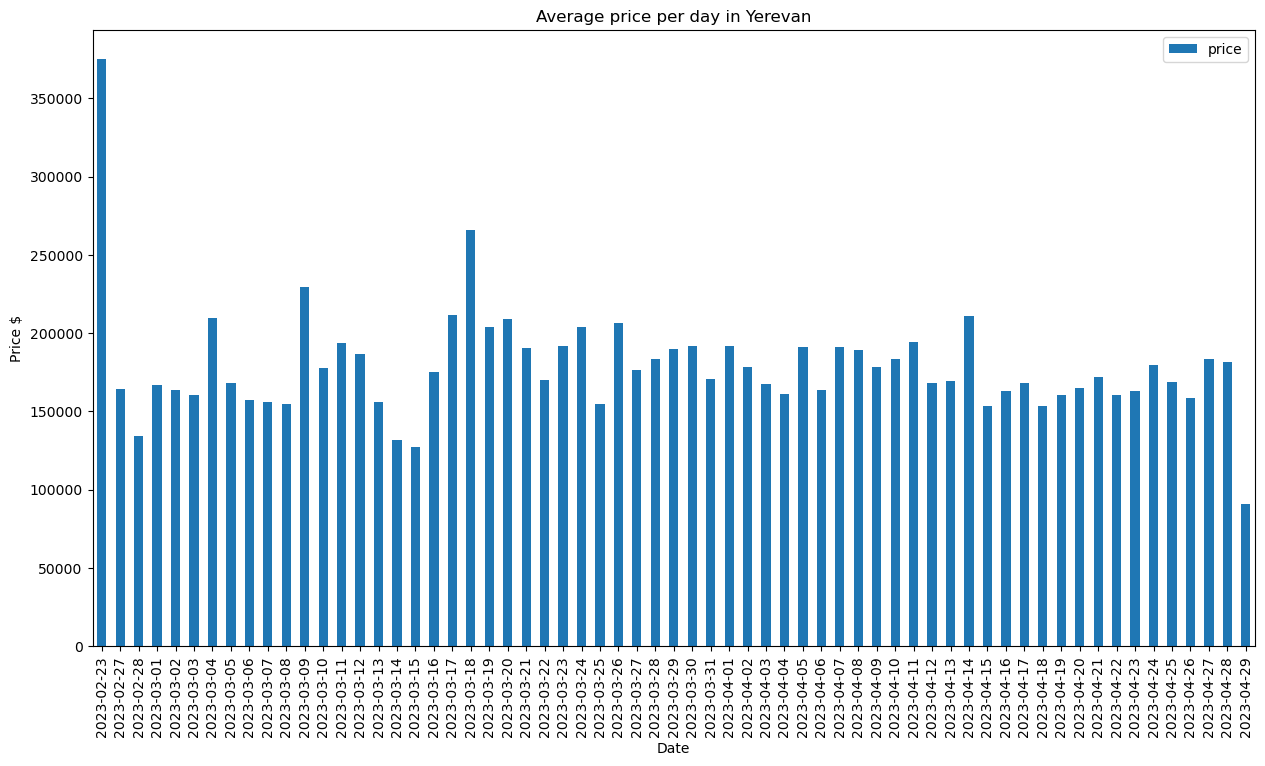

In [3]:
import matplotlib.pyplot as plt
locations = YEREVAN

updates_in_location = []
for id, item in apt.updates.items():
    if item['location'] in locations:
        for update in item['updates']:
            updates_in_location.extend(item['updates'])

df = pd.DataFrame(updates_in_location, columns=['date', 'price'])
df['date'] = pd.to_datetime(df['date']).dt.date
grouped_data = df.groupby('date').mean()

grouped_data.plot(kind='bar', title='Average price per day in '+locations.NAME, xlabel='Date', ylabel='Price $', figsize=(15,8))
plt.savefig('barplot.png')
plt.show()

In [9]:
import pandas as pd


